100%|██████████| 170498071/170498071 [00:03<00:00, 43314095.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 1.7611
Accuracy on test set: 46.15%
Epoch [2/10], Loss: 1.3692
Accuracy on test set: 54.24%
Epoch [3/10], Loss: 1.1831
Accuracy on test set: 62.31%
Epoch [4/10], Loss: 1.0581
Accuracy on test set: 65.68%
Epoch [5/10], Loss: 0.9682
Accuracy on test set: 70.61%
Epoch [6/10], Loss: 0.9020
Accuracy on test set: 70.52%
Epoch [7/10], Loss: 0.8582
Accuracy on test set: 71.47%
Epoch [8/10], Loss: 0.8105
Accuracy on test set: 74.68%
Epoch [9/10], Loss: 0.7749
Accuracy on test set: 75.23%
Epoch [10/10], Loss: 0.7413
Accuracy on test set: 76.30%


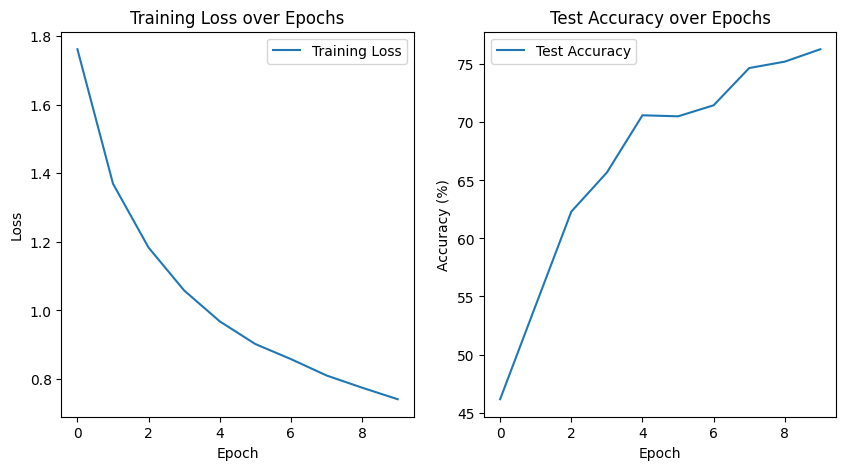

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations for the training and test set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Define AlexNet architecture (modified for CIFAR-10)
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Modified: Reduced kernel_size and stride, added padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Modified: Reduced kernel_size and stride to 2
            nn.Conv2d(64, 192, kernel_size=3, padding=1),  # Modified: Reduced kernel_size, added padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Modified: Reduced kernel_size and stride to 2
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # Modified: Reduced kernel_size, added padding
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # Modified: Reduced kernel_size, added padding
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Modified: Reduced kernel_size, added padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Modified: Reduced kernel_size and stride to 2
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            # Modified: Adjusted input size for the first linear layer
            nn.Linear(256 * 4 * 4, 4096), # The input size to the linear layer is calculated as channels * height * width. This assumes the spatial size of the feature maps after all convolutional and pooling layers is 4x4. Adjust the number accordingly if the feature map size is different.
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # Modified: Adjusted view to match the output of the features module
        x = x.view(x.size(0), 256 * 4 * 4) # Change this number (256*4*4) to match the spatial size of the features map, calculate this as the input shape (32x32x3) and walk through the convolutional layers in 'features'
        x = self.classifier(x)
        return x


# Initialize the AlexNet model
net = AlexNet(num_classes=10)
net = net.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
def train(net, trainloader, testloader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

        # Validate the model on the test set
        test_accuracy = evaluate(net, testloader)
        test_accuracies.append(test_accuracy)

    return train_losses, test_accuracies

# Evaluation function
def evaluate(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

# Train the model and evaluate it
num_epochs = 10
train_losses, test_accuracies = train(net, trainloader, testloader, criterion, optimizer, num_epochs)

# Plot the training loss and test accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.show()
